## Preprocessing 1

(1) Apply Normalization


(2) Apply Wavelet denoising with the chosen parameters (wavelet and level)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from sklearn.pipeline import Pipeline
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'preprocessing')))
from transforms import Normalize, ApplyHOG, DenoiseWavelet
from joblib import Parallel, delayed

In [5]:
with open("../configs/configs.json", "r") as f:
    configs = json.load(f)
    
width = configs["InputImages"]["Width"]
height = configs["InputImages"]["Height"]
wavelet = configs["Preprocessing"]["WaveletDenoising"]["Wavelet"]
level = configs["Preprocessing"]["WaveletDenoising"]["Level"]
thresholding = configs["Preprocessing"]["WaveletDenoising"]["Thresholding"]
img_path = configs["DataPaths"]["TrainImages"]
visualize = configs["Preprocessing"]["HOG"]["Visualize"]

Since we have a dataset with each row representing an image, and each image has 110x110 pixeis, then each row will have 12100 columns representing the pixels

If we want to process the images, we must reshape them back to 110x110

In [6]:
train_images = pd.read_csv(img_path, header=None)

numpy_images = train_images.values.reshape(-1, width, height).astype(np.float32)

let's check numpy_images shape to see if everything is correct

In [7]:
np.shape(numpy_images)

(7000, 110, 110)

Create the pipeline and apply it to the numpy dataset

In [8]:
pipeline = Pipeline([
    ('normalize', Normalize()),
    ('denoise_wavelet', DenoiseWavelet(wavelet, level, thresholding))
])

processed_images = np.array([pipeline.transform(img) for img in numpy_images])

c:\Users\Isabelle\miniconda3\envs\api\lib\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


We can check shape after processing images

In [9]:
np.shape(processed_images)

(7000, 110, 110)

Let's check some examples after denoising

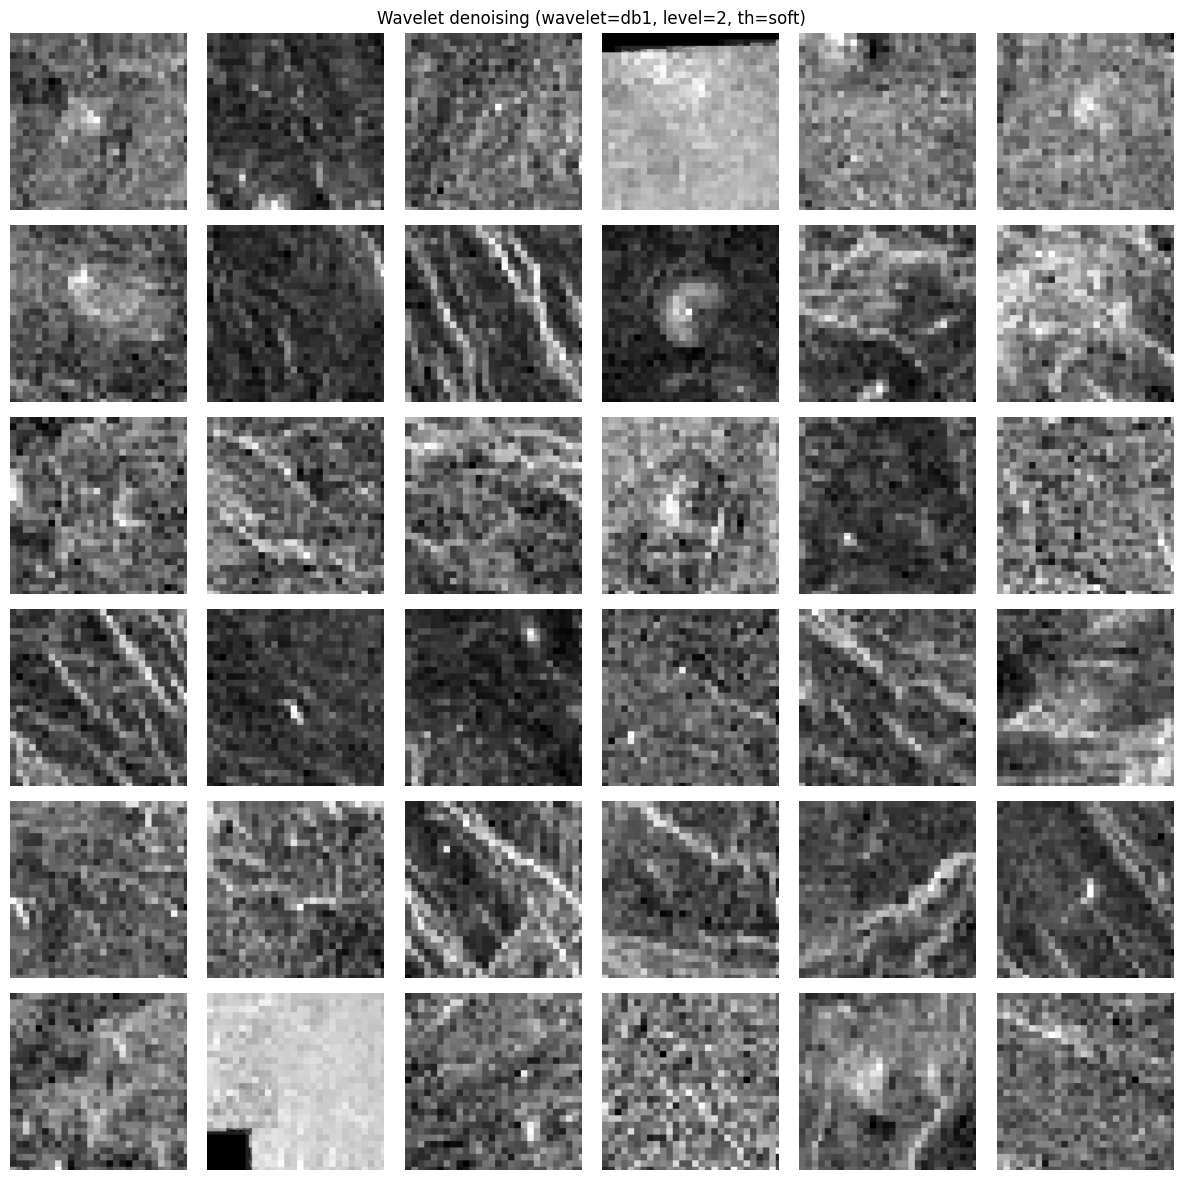

In [10]:
num_images = 36
sample_images = processed_images[:num_images]

fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()  

for i in range(num_images):
    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].axis('off') 

fig.suptitle(f'Wavelet denoising (wavelet={wavelet}, level={level}, th={thresholding})')
plt.tight_layout()
plt.show()

Tha images now seem to have enhanced features, less details and less noise

We still don't know if this strategy will work compared to gaussian blur, to know that, we must test whithin the models

Since the images are partially denoised, we can apply HOG to enhance the most important features

To make it faster, we can use Parallel from Joblib and use all cores to process data

In [11]:
pipeline = Pipeline([
    ('normalize', Normalize()),
    ('denoise_wavelet', DenoiseWavelet(wavelet, level, thresholding)),
    ('hog', ApplyHOG(visualize))
])

def process_image(img):
    return pipeline.transform(img)

num_jobs = -1 
hog_images = Parallel(n_jobs=num_jobs)(delayed(process_image)(img) for img in numpy_images)

Let's take a look at some visual examples

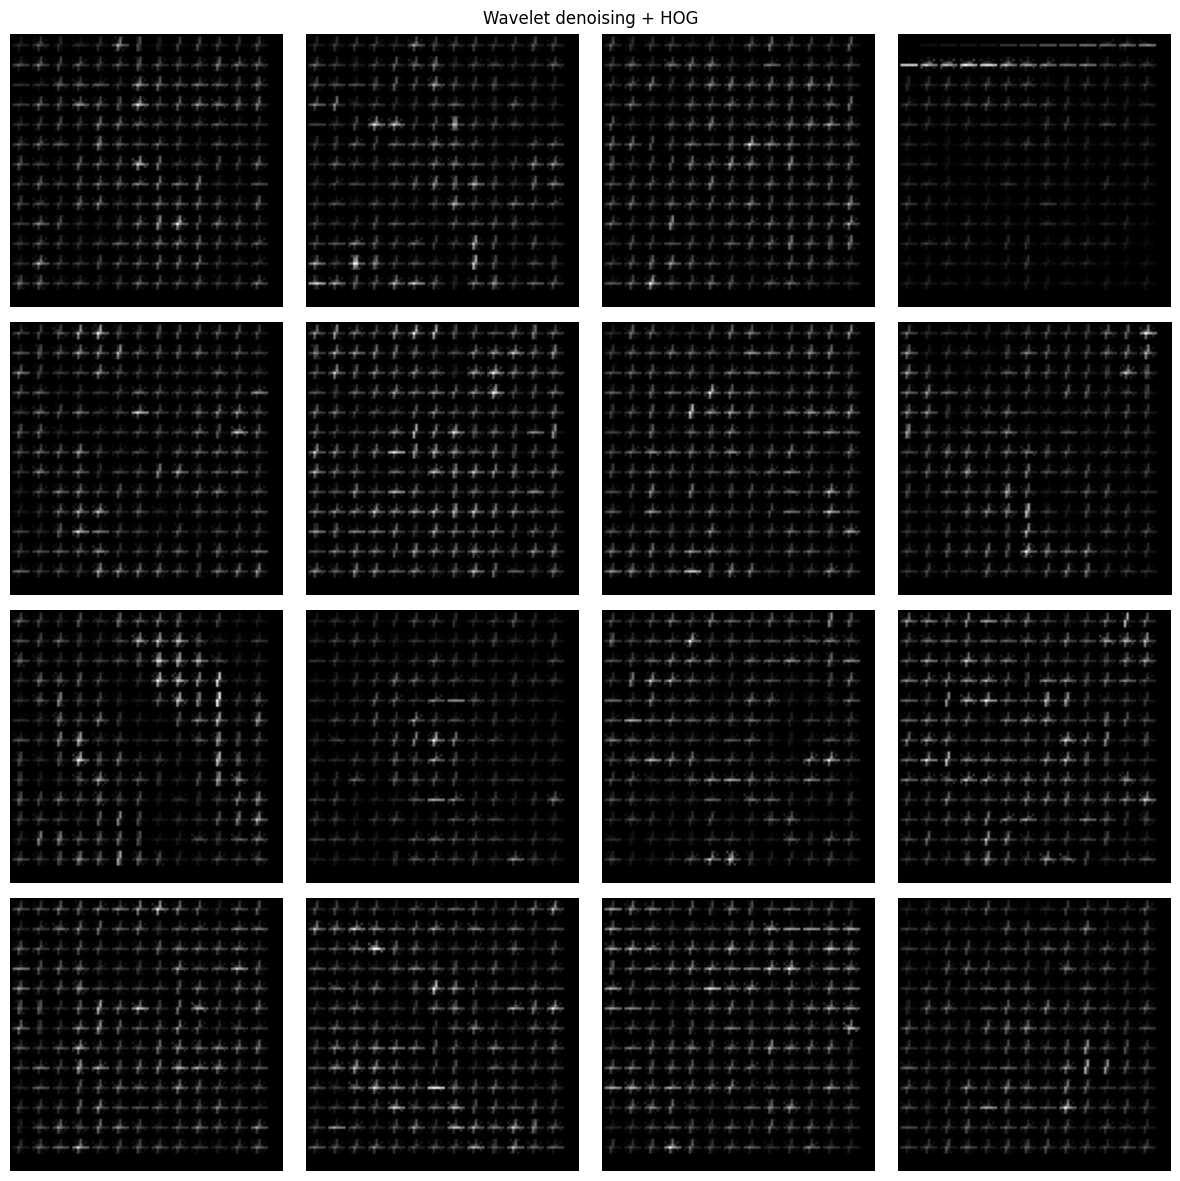

In [12]:
num_images = 16
sample_images = hog_images[:num_images]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()  

for i in range(num_images):
    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].axis('off')

fig.suptitle(f'Wavelet denoising + HOG')
plt.tight_layout()
plt.show()

finally, we can check the final shape in hog_images

In [13]:
np.shape(hog_images)

(7000, 110, 110)

We can prepare a workflow to preprocess data using these functions and send them to the model